In [35]:
import glob
import os
import sys
import librosa
import librosa.display
import librosa.core
import math
import seaborn as sns
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import signal


import IPython.display
from IPython.display import Video


import pickle
import pdb
import h5py
    
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline 

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

%load_ext autoreload
%autoreload 2

sns.set()
plt.rcParams.update({'font.family':'Times New Roman'})

#============= import for DL audio ============
import matplotlib.pyplot as plt
from scipy.io import wavfile
import argparse
import os
from glob import glob
import numpy as np
import pandas as pd
from librosa.core import resample, to_mono
from tqdm import tqdm

#Import required modules
from sklearn.decomposition import PCA
 
from os import listdir
from os.path import isfile, join

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
directory1 = '/home/marklee/IAM/vibration_project/umass/audio/umass1_audio/'

In [169]:
#input: directory path
#output: 3 [2xT] audio concatenated array
def get_audio_from_directory(directory_path):
    
    leaf_audio_list = []
    twig_audio_list = []
    trunk_audio_list = []

    leaf_audio_list_total = np.array([[],[]])
    twig_audio_list_total  = np.array([[],[]])
    trunk_audio_list_total  = np.array([[],[]])
    
    #get filenames from directory
    filenames = [f for f in listdir(directory_path) if isfile(join(directory_path, f))]

    # [ [2,T0], [2,T1] ].... length of item X L/R X T of audio sample
    for name in filenames:
        complete_name = directory_path + name
        audio_input, fs = librosa.load(complete_name, mono=False)

        #TODO:
        #include filter here?
        #include trim here?

        if 'leaf' in name:
            leaf_audio_list.append(audio_input) #just get 1st audio channel

        elif 'twig' in name:
            twig_audio_list.append(audio_input) #just get 1st audio channel

        elif 'trunk' in name:
            trunk_audio_list.append(audio_input) #just get 1st audio channel

        else:
            print(f"incorrect audio name")

    #     audio_input, fs = librosa.load(complete_name, mono=False)
    #     audio_list.append(audio_input[0]) #just get 1st audio channel


    item_len = len(trunk_audio_list)

    #for all 3 classes, merge T0...T6 to just one T
    for i in range (item_len):
        leaf_audio_list_total = np.concatenate((leaf_audio_list_total,leaf_audio_list[i]), axis=1)
        twig_audio_list_total = np.concatenate((twig_audio_list_total,twig_audio_list[i]), axis=1)
        trunk_audio_list_total = np.concatenate((trunk_audio_list_total,trunk_audio_list[i]), axis=1)

    return leaf_audio_list_total, twig_audio_list_total, trunk_audio_list_total

In [170]:
leaf, twig, trunk = get_audio_from_directory(directory1)

In [171]:
print(f"leaf: {leaf.shape}, twig: {twig.shape}, trunk: {trunk.shape}")

leaf: (2, 1711211), twig: (2, 2007163), trunk: (2, 2351118)


In [172]:
from tempfile import TemporaryFile
from numpy import save

np.save('leaf.npy', leaf)

In [98]:
IPython.display.Audio(twig[0], rate=fs)

No handles with labels found to put in legend.


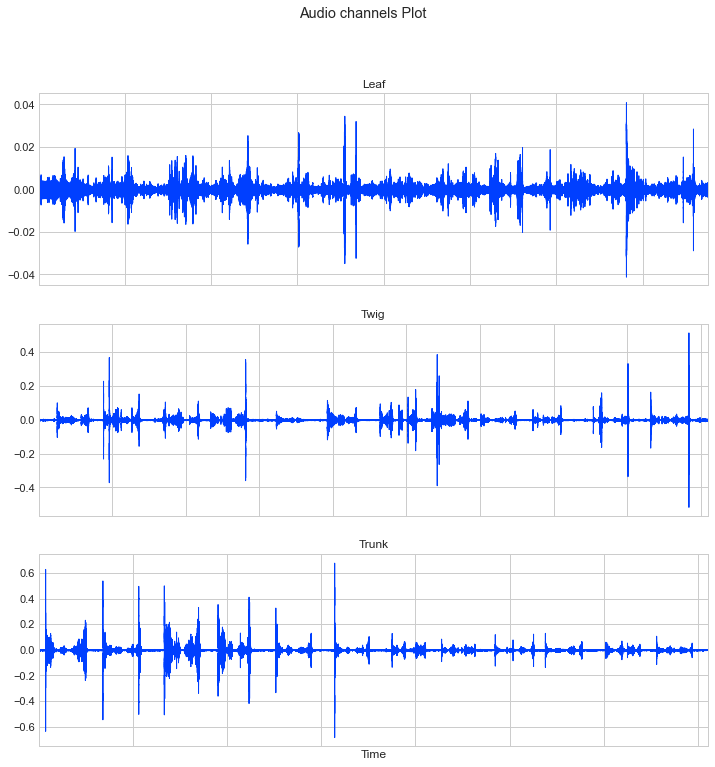

In [147]:
    
fig = plt.figure(figsize=(12,12))
fig.suptitle('Audio channels Plot')

ax1 = plt.subplot(3,1,1)
librosa.display.waveplot(leaf[0],sr=fs)
plt.title("Leaf")
plt.setp( ax1.get_xticklabels(), visible=False)
ax1.xaxis.set_label_text('')

ax2 = plt.subplot(3,1,2)
librosa.display.waveplot(twig[0], sr=fs)
plt.title("Twig")
plt.setp( ax2.get_xticklabels(), visible=False)
ax2.xaxis.set_label_text('')

ax3 = plt.subplot(3,1,3)
librosa.display.waveplot(trunk[0], sr=fs)
plt.title("Trunk")
plt.setp( ax3.get_xticklabels(), visible=False)
ax3.xaxis.set_label_text('')


plt.legend(loc=2)
ax3.set_xlabel("Time")
plt.show()


In [206]:
def envelope(y, rate, threshold):
#     print("received y:", y.shape)
#     print("y", y)
    mask = []
    y = pd.Series(y).apply(np.abs)
#     print("y after series:", y.shape)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()
#     print("y_mean:", y_mean.shape)
    
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

In [207]:

threshold_leaf = 0.001
threshold_twig = 0.01
threshold_trunk = 0.01

mask_leaf, envelop = envelope(leaf[0], fs, threshold=threshold_leaf)
audio_threshold_leaf =  audio_leaf_total[mask_leaf]

mask_twig, envelop = envelope(twig[0], fs, threshold=threshold_twig)
audio_threshold_twig =  audio_twig_total[mask_twig]

mask_trunk, envelop = envelope(trunk[0], fs, threshold=threshold_trunk)
audio_threshold_trunk =  audio_trunk_total[mask_trunk]

No handles with labels found to put in legend.


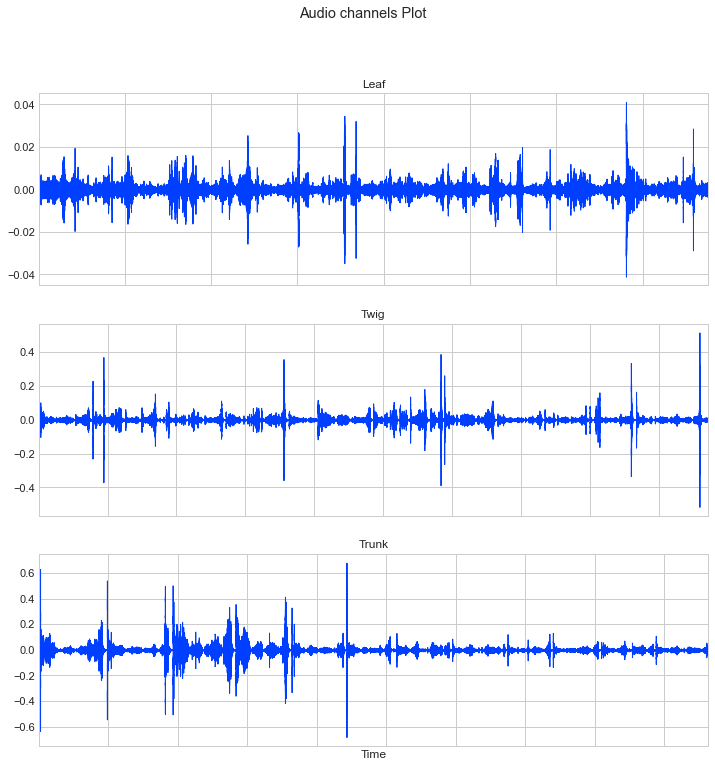

In [149]:
    
fig = plt.figure(figsize=(12,12))
fig.suptitle('Audio channels Plot')

ax1 = plt.subplot(3,1,1)
librosa.display.waveplot(audio_threshold_leaf,sr=fs)
plt.title("Leaf")
plt.setp( ax1.get_xticklabels(), visible=False)
ax1.xaxis.set_label_text('')

ax2 = plt.subplot(3,1,2)
librosa.display.waveplot(audio_threshold_twig, sr=fs)
plt.title("Twig")
plt.setp( ax2.get_xticklabels(), visible=False)
ax2.xaxis.set_label_text('')

ax3 = plt.subplot(3,1,3)
librosa.display.waveplot(audio_threshold_trunk, sr=fs)
plt.title("Trunk")
plt.setp( ax3.get_xticklabels(), visible=False)
ax3.xaxis.set_label_text('')


plt.legend(loc=2)
ax3.set_xlabel("Time")
plt.show()


In [173]:
audio_threshold_leaf = leaf[0]
audio_threshold_twig = twig[0]
audio_threshold_trunk = trunk[0]

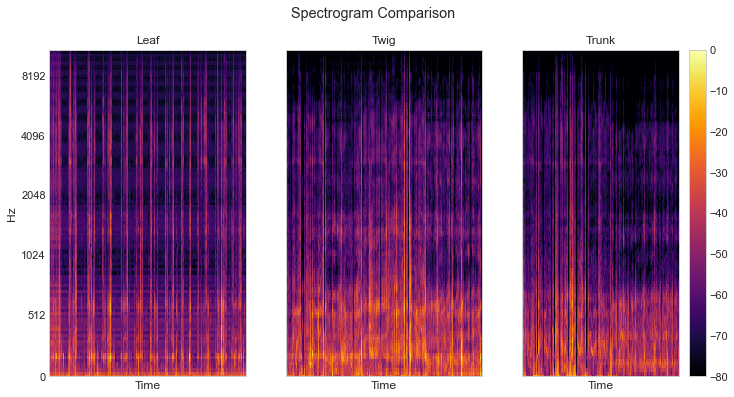

In [208]:
n_fft = 2048 #standard for audio (speech is 512)
hop_length = 512 #n_fft / 4
n_mels = 128
mel = librosa.filters.mel(sr=fs, n_fft=n_fft, n_mels=n_mels)

fig = plt.figure(figsize=(12,6))
fig.suptitle('Spectrogram Comparison')

ax1 = plt.subplot(1,3,1)
S_leaf = librosa.feature.melspectrogram(audio_threshold_leaf, sr=fs, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB_leaf = librosa.power_to_db(S_leaf, ref=np.max)
img_plot = librosa.display.specshow(S_DB_leaf, sr=fs, hop_length=hop_length, x_axis='time', y_axis='mel', cmap=cm.inferno);

plt.title("Leaf")
plt.setp( ax1.get_xticklabels(), visible=False)
ax1.xaxis.set_label_text('')
ax1.set_xlabel("Time")

ax2 = plt.subplot(1,3,2)
S_twig = librosa.feature.melspectrogram(audio_threshold_twig, sr=fs, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB_twig = librosa.power_to_db(S_twig, ref=np.max)
librosa.display.specshow(S_DB_twig, sr=fs, hop_length=hop_length, x_axis='time', y_axis='mel', cmap=cm.inferno);

plt.title("Twig")
plt.setp( ax2.get_xticklabels(), visible=False)
plt.setp( ax2.get_yticklabels(), visible=False)
ax2.xaxis.set_label_text('')
ax2.yaxis.set_label_text('')
ax2.set_xlabel("Time")

ax3 = plt.subplot(1,3,3)
S_trunk = librosa.feature.melspectrogram(audio_threshold_trunk, sr=fs, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB_trunk = librosa.power_to_db(S_trunk, ref=np.max)
librosa.display.specshow(S_DB_trunk, sr=fs, hop_length=hop_length, x_axis='time', y_axis='mel', cmap=cm.inferno);

plt.title("Trunk")
plt.setp( ax3.get_xticklabels(), visible=False)
plt.setp( ax3.get_yticklabels(), visible=False)
ax3.xaxis.set_label_text('')
ax3.yaxis.set_label_text('')
ax3.set_xlabel("Time")
plt.colorbar()
plt.show()




In [209]:
def augment_audio(audio_in, label, duration, stride):
    X_list = []
    y_list = []
    
    L = len(audio_in)

    data_count = np.ceil((L - duration + 1)/stride).astype(int)
    
    for i in range (data_count):
        audio_slice = audio_in[i*stride:i*stride+duration]
        X_list.append(audio_slice)
        y_list.append(int(label))
    
    X_np = np.array(X_list)
    y_np = np.array(y_list)

    return X_np, y_np, data_count

In [210]:
sample_duration = int(fs/1) #1 sec duration samples
stride_length = int(fs/1) #1000 msec stride between samples

label = {
    "leaf" : 1,
    "twig" : 2,
    "trunk": 3
}

In [211]:
#===== augment time audio data ======
audio_leaf_data, _, count = augment_audio(audio_threshold_leaf,label['leaf'],sample_duration,stride_length)
audio_twig_data, _, count = augment_audio(audio_threshold_twig,label['twig'],sample_duration,stride_length)
audio_trunk_data, _, count = augment_audio(audio_threshold_trunk,label['trunk'],sample_duration,stride_length)

In [212]:
#============ trim to same length ================
min_length = np.min([audio_leaf_data.shape[0],audio_twig_data.shape[0],audio_trunk_data.shape[0]])
audio_leaf_data = audio_leaf_data[0:min_length,:]
audio_twig_data = audio_twig_data[0:min_length,:]
audio_trunk_data = audio_trunk_data[0:min_length,:]
min_length

35

In [213]:
print(f"leaf: {audio_leaf_data.shape}, twig: {audio_twig_data.shape}, trunk: {audio_trunk_data.shape}")

leaf: (35, 22050), twig: (35, 22050), trunk: (35, 22050)


In [214]:
def convert_audio_data_to_spec(audio_data_table_, label):
    
    spectrogram_list = []
    y_list = []
    num, sample_length_ = audio_data_table_.shape
    
    # convert audio data to spectrogram data
    n_fft = 2048 #standard for audio (speech is 512)
    hop_length = 512 #n_fft / 4
    n_mels = 128
    mel = librosa.filters.mel(sr=fs, n_fft=n_fft, n_mels=n_mels)

    for i in range (num):
        
        S_ = librosa.feature.melspectrogram(audio_data_table_[i,:], sr=fs, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_DB_ = librosa.power_to_db(S_, ref=np.max)
        
        #mean across time
        S_DB_flat = np.mean((S_DB_),axis=1) 
        
        spectrogram_list.append(S_DB_flat)
        y_list.append(int(label))
        
    X_spec = np.array(spectrogram_list)
    y_spec = np.array(y_list)
    
    return X_spec,y_spec, num
    

In [215]:
#convert audio to spec
X_leaf, y_leaf, leaf_count = convert_audio_data_to_spec(audio_leaf_data, label['leaf'])
X_twig, y_twig, twig_count = convert_audio_data_to_spec(audio_twig_data, label['twig'])
X_trunk, y_trunk, leaf_trunk = convert_audio_data_to_spec(audio_trunk_data, label['trunk'])

In [216]:
print(f"{X_leaf.shape}, {X_twig.shape}, {X_trunk.shape}")

(35, 128), (35, 128), (35, 128)


In [217]:
#combine all data X
X_table1 = np.concatenate((X_leaf, X_twig, X_trunk),axis=0)
scatter_color = np.concatenate((y_leaf, y_twig, y_trunk), axis=0)

#print out data table shape
print(f"shape {X_table1.shape}, {scatter_color.shape}") #num items x flattened features


shape (105, 128), (105,)


In [218]:
#normalize before doing PCA
from sklearn.preprocessing import StandardScaler
X_table1_norm = StandardScaler().fit_transform(X_table1)



In [219]:
# S_DB_table1_norm[:,0].shape
np.var(X_table1_norm[:,0])

1.0000000000000002

In [220]:
#how many PCA components?
pca = PCA()
S_DB_table_pca = pca.fit_transform(X_table1_norm) 
# S_DB_table_pca = pca.fit_transform(S_DB_table1) 

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

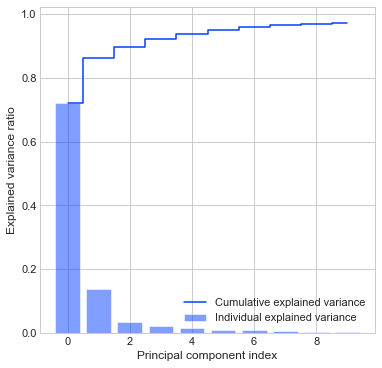

In [221]:
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca[0:10])), exp_var_pca[0:10], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues[0:10])), cum_sum_eigenvalues[0:10], where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()


In [222]:
exp_var_pca[0:3]

array([0.72224426, 0.13858898, 0.0361492 ])

In [223]:
#reduce dim with PCA
pca = PCA(2) # we need 2 principal components.
X_table1_norm_pca1 = pca.fit_transform(X_table1_norm)
#print out data table shape
print(f"pca shape {X_table1_norm_pca1.shape}")

pca shape (105, 2)


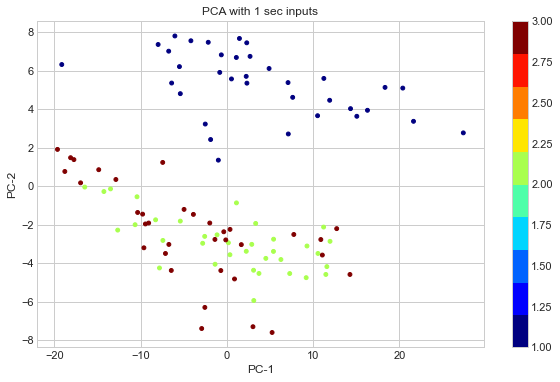

In [224]:
#scatter plot
plt.style.use('seaborn-whitegrid') 
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(X_table1_norm_pca1[:, 0], X_table1_norm_pca1[:, 1], s = 15,
            cmap = c_map , c = scatter_color)

plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.title("PCA with 1 sec inputs")

plt.colorbar()
plt.show()